In [1]:
import torch
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F

In [2]:
# Open training data
with open(f"./names.txt") as file:
    words = file.readlines()
    
# Make list of each word from data
words = [word.strip() for word in words]

# store alphabet of letters from data. 
alphabet = set()
alphabet.add('<S>')
alphabet.add('<E>')

for word in words:
    for char in word:
        alphabet.add(char)


# Store alphabet to index mapping with reverse functionality. 
alphabet = list(alphabet)
alphabet = sorted(alphabet)
char_to_int = dict()
int_to_char = dict()

for index, char in enumerate(alphabet):
    char_to_int[char] = index
    int_to_char[index] = char

# Store token counts
token_counts = dict()

# Iterate of each word
for word in words:
    
    # Add stop and start tokens
    chst = ['<S>'] + [char for char in word] + ['<E>']
    # print(type(chst))
    
    # This will include up to ending token in right index
    for tuplet in zip(chst, chst[1:]):
        # Store running counts of each token
        if tuplet in token_counts:
            token_counts[tuplet] += 1
        else: 
            token_counts[tuplet] = 1
    
    

In [3]:
# Create 2D tensor to store frequency of bigram pairs. 
data = torch.zeros((len(alphabet), len(alphabet)), dtype=torch.int32)


char_to_int
# # Iterate over tuplets
for tuplet in token_counts.items():
    # store characters pairs and freq
    chpairs, freq = tuplet
    # Assign index of data according to character values
    data_index = [char_to_int[char] for char in chpairs]
    # print(chpairs, data_index)
    data[data_index[0]][data_index[1]] = freq
    


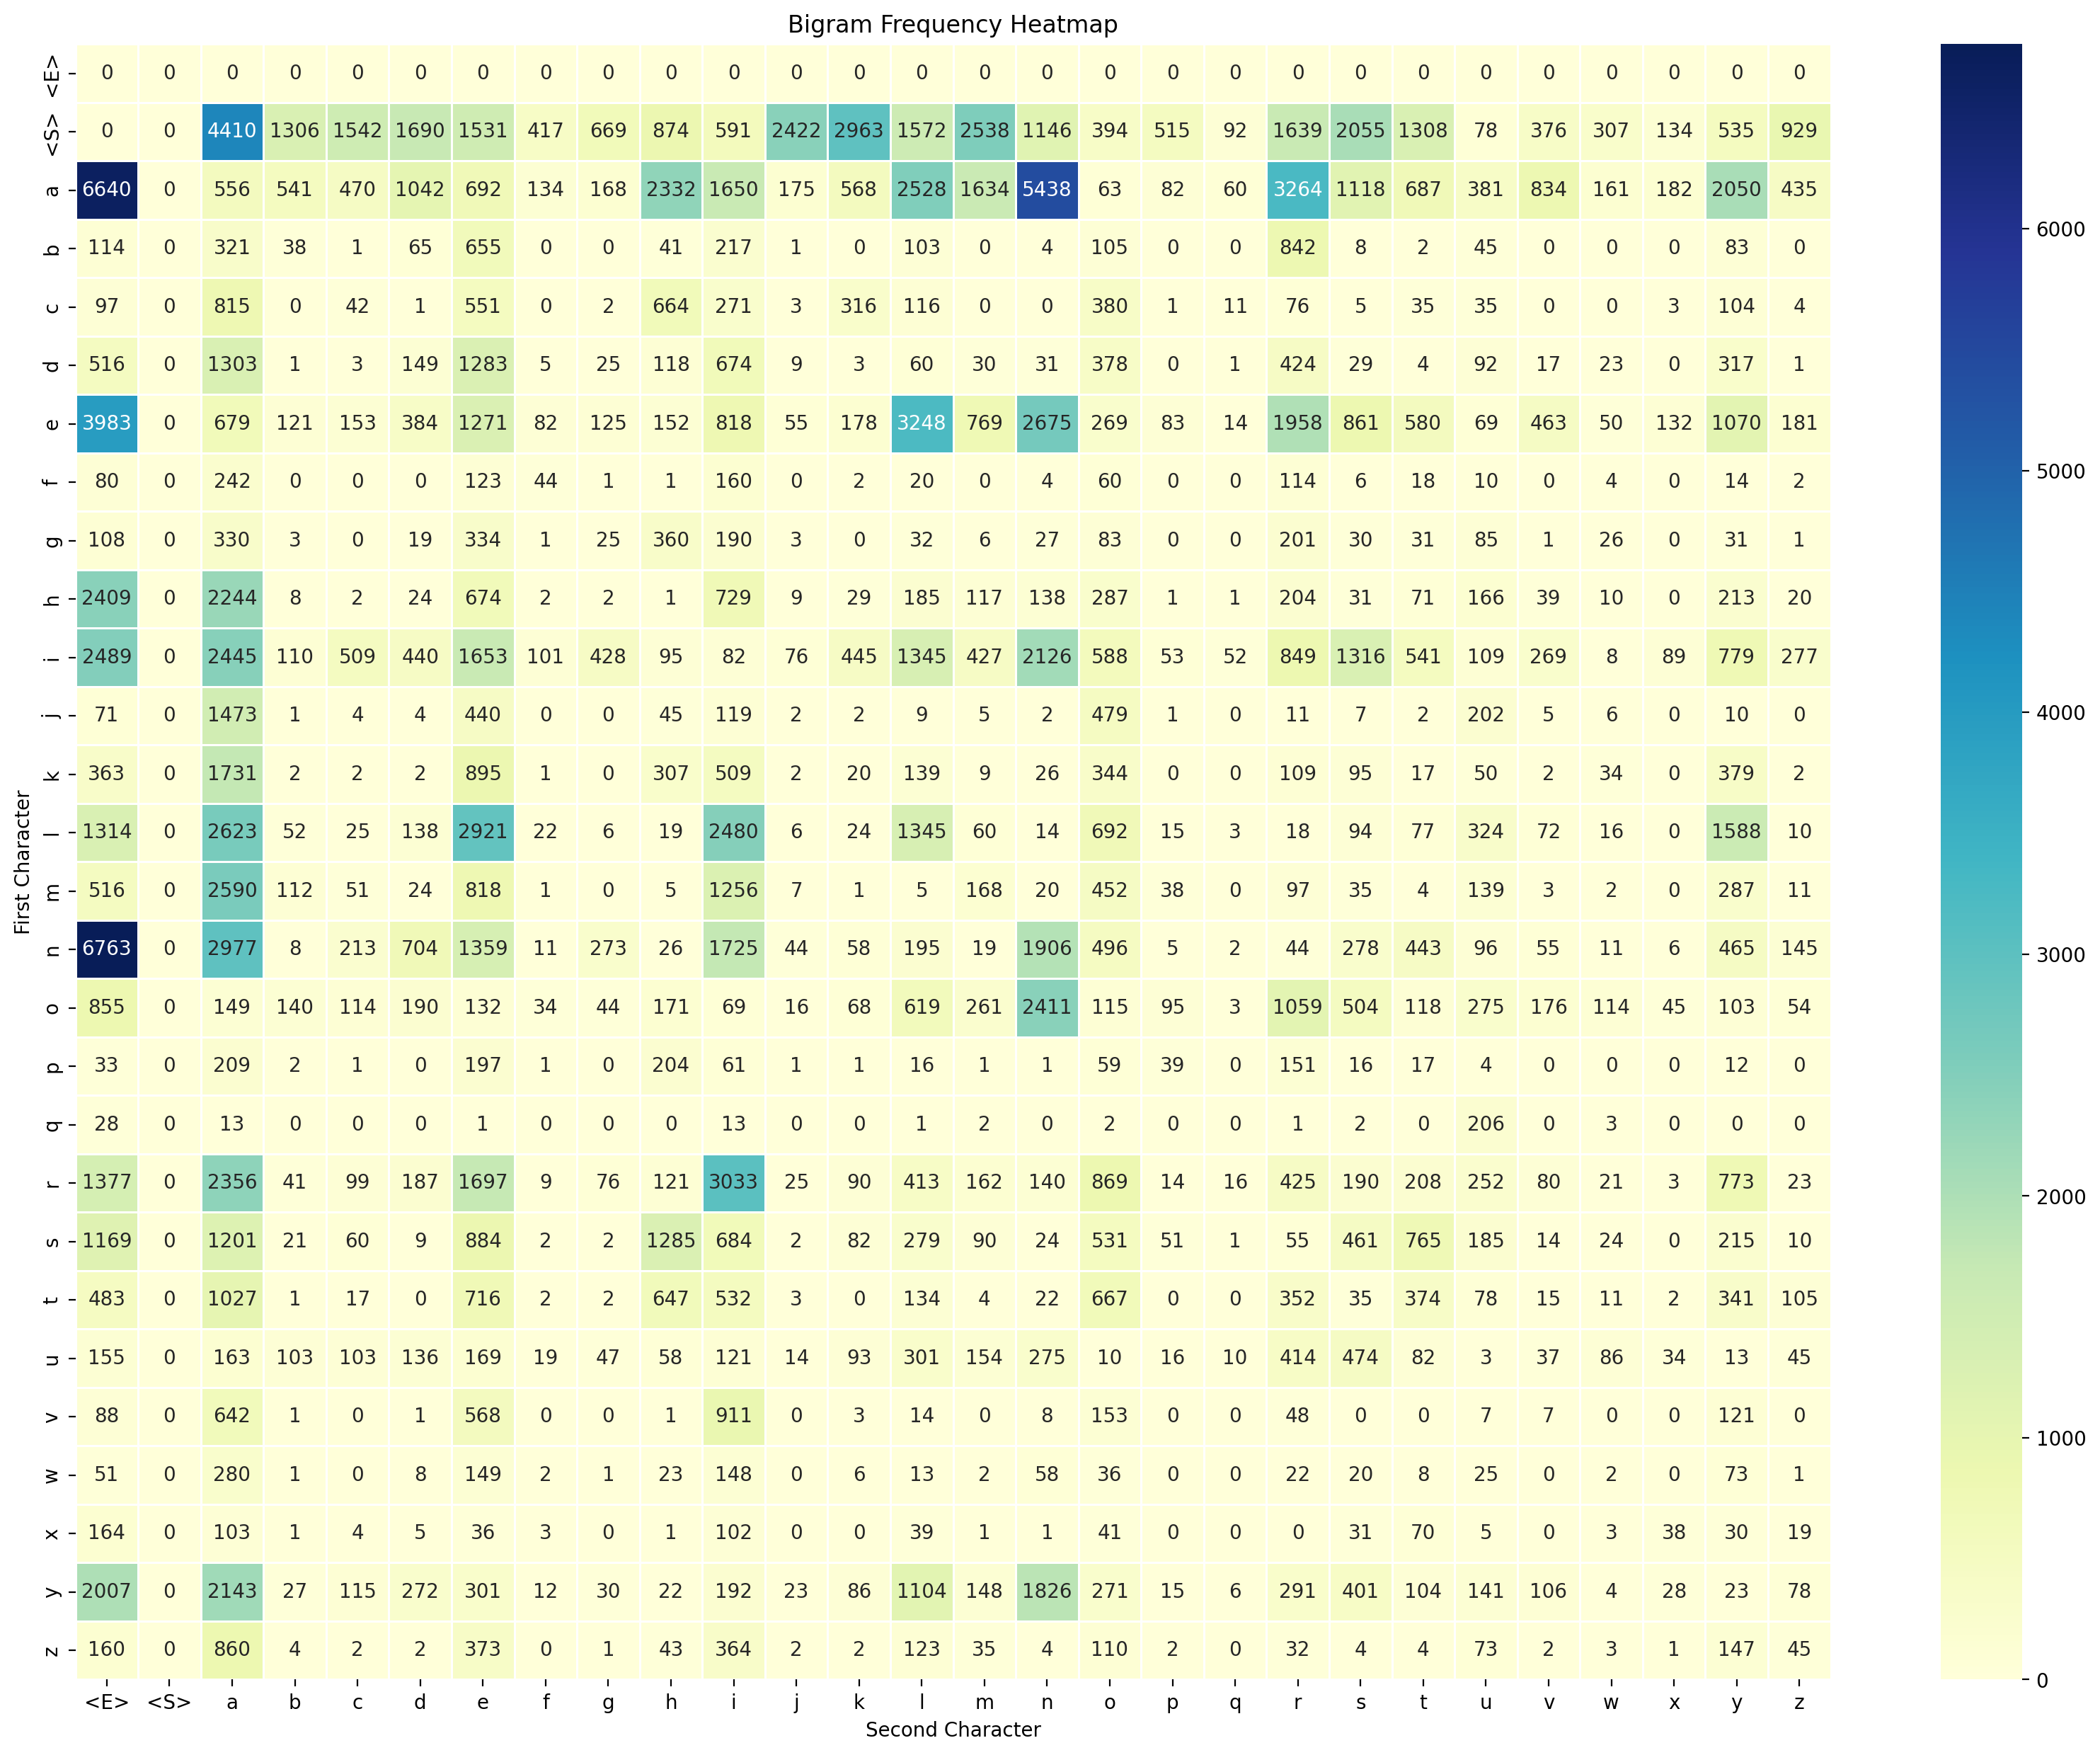

In [4]:
# Convert data tensor to numpy array
data_np = data.numpy()

# Create heatmap using Seaborn with annotations
plt.figure(figsize=(20, 15), dpi=200)
sns.heatmap(data_np, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=.5)

# Set custom tick labels for x-axis (Second Character)
plt.xticks(np.arange(len(alphabet)) + 0.5, [int_to_char[i] for i in range(len(alphabet))])
# Set custom tick labels for y-axis (First Character)
plt.yticks(np.arange(len(alphabet)) + 0.5, [int_to_char[i] for i in range(len(alphabet))])

# Set labels and title
plt.title('Bigram Frequency Heatmap')
plt.xlabel('Second Character')
plt.ylabel('First Character')

# Display the plot
plt.show()

In [5]:
# Create a generator object
generator = torch.Generator()

# Define the value to fill
epsilon = 1e-10

# Set seed using manual_seed method
generator.manual_seed(42)

# # Convert data to float for probabilities
norm_data = (data + epsilon).to(torch.float32)

# Normalize data according to valid pdf
norm_data /= norm_data.sum(dim=1, keepdim=True)

# # # Add very small number to clear null values
# norm_data[0].fill_(epsilon)

# print(norm_data)


In [6]:
# Store list of sampled words
sample_outcome = []

for _ in range(10):
    # Word initializes with start token 
    ix = 1
    word = int_to_char[ix]

    while True:
        
        # get random character given previous character 
        ix = torch.multinomial(norm_data[ix], num_samples=1, generator=generator).item()
        
        # store new character token
        char = int_to_char[ix]
        
        # add sampled letter to word 
        word += char
        
        # check if terminating token has been reached
        if char == '<E>':
            # add word to list of sampled words
            sample_outcome.append(word)
            break
        

In [7]:
training = words[0]

inputs = []
targets = []

# Add start and end character tokens
training = ['<S>'] + [char for char in training] + ['<E>']

# Iterate over bigrams 
for ch1, ch2 in zip(training, training[1:]):
    # add prior
    inputs.append(char_to_int[ch1])
    # add target
    targets.append(char_to_int[ch2])

In [8]:
inputs_enc = F.one_hot(torch.tensor(inputs), num_classes=28)
inputs_enc = inputs_enc.to(torch.float32)

targets_enc = F.one_hot(torch.tensor(targets), num_classes=28)
targets_enc = targets_enc.to(torch.float32)

In [9]:
weights = torch.rand((28, 28), requires_grad=True)
weights = weights.to(torch.float32)
# print(inputs_enc.T.shape)

In [10]:
# Calculate logits, unnormalized pre-probabilities
logits = weights @ inputs_enc.T
# print(logits)

# Transpose for readability
logits = logits.T

# Convert each output to valid probability distribution, across cols
# dim=0 / each row is a probability distribution over the alphabet given the prior / input token (char)
probabilities = logits.exp() / logits.exp().sum(dim=1, keepdim=True)
# print(probabilities) #compare to softmax

# Apply softmax to output of linear layer
softmax = F.softmax(logits, dim = 1)
# print(softmax) #compare to probabilities

# Calculate negative log likelihood = loss of data for practice (GLM)
lik = softmax[torch.arange(5),targets]
log_lik = lik.log().mean()
neg_log_lik = -log_lik
loss = neg_log_lik
print(loss)

# Compare calculated loss with cross entropy loss. 
criterion = torch.nn.CrossEntropyLoss()
criterion_result = criterion(softmax, targets_enc)
print(criterion_result)



tensor(3.4218, grad_fn=<NegBackward0>)
tensor(3.3331, grad_fn=<DivBackward1>)


In [11]:
targets

[6, 14, 14, 2, 0]

In [12]:
# Clear out prev gradients
weights.grad = None

# Backprop
loss.backward()

# Update weights
weights.data -= .01 * weights.grad

In [13]:
criterion = torch.nn.CrossEntropyLoss()
softmax.shape



torch.Size([5, 28])

In [14]:
# Initialize bigram array for storage of inputs and targets
train_inputs = []
train_targets = []


# Iterate over every word
for word in words:
    
    # append start and end tokens to word
    chst = ['<S>'] + [char for char in word] + ['<E>']
    
    # Add bigram to training data.
    for ch1, ch2 in zip(chst, chst[1:]):
        
        # add data to training set
        train_inputs.append(char_to_int[ch1])
        train_targets.append(char_to_int[ch2])
        
    # Define Stopping point 
    # no stopping point necessary
    

In [82]:
# Convert data to tensors
train_inputs = torch.as_tensor(train_inputs)
train_targets = torch.as_tensor(train_targets)

# Initialize training weights radnomly, uniform 0 to 1 exclusive
training_weights = torch.rand(28, 28, dtype=torch.float32, requires_grad=True)

# Encode training data. 
train_inputs_enc = F.one_hot(train_inputs, num_classes=28).float()

# train_inputs_enc.shape -> 228146 x 28
train_targets_enc = F.one_hot(train_targets, num_classes=28).float()

In [91]:

for k in range(100):
    
    # Foward pass
    # Calculate linear layer output
    logits = train_inputs_enc @ training_weights.T

    # normalization
    softmax = F.softmax(logits, dim=1)

    # store likelihood of data
    mle_prob = softmax[torch.arange(len(train_targets)), train_targets]

    # conver to log likelihood
    neg_log_lik = -mle_prob.log()

    # loss across batch
    loss = neg_log_lik.mean()
    print(loss)

    # Clear weights if not first pass
    training_weights.grad.zero_()

    # Backwrd pass calculating gradients
    loss.backward()

    # Update Training weights 
    training_weights.data -= .1 * training_weights.grad


tensor(3.3015, grad_fn=<MeanBackward0>)
tensor(3.3009, grad_fn=<MeanBackward0>)
tensor(3.3004, grad_fn=<MeanBackward0>)
tensor(3.2998, grad_fn=<MeanBackward0>)
tensor(3.2993, grad_fn=<MeanBackward0>)
tensor(3.2987, grad_fn=<MeanBackward0>)
tensor(3.2982, grad_fn=<MeanBackward0>)
tensor(3.2977, grad_fn=<MeanBackward0>)
tensor(3.2971, grad_fn=<MeanBackward0>)
tensor(3.2966, grad_fn=<MeanBackward0>)
tensor(3.2960, grad_fn=<MeanBackward0>)
tensor(3.2955, grad_fn=<MeanBackward0>)
tensor(3.2950, grad_fn=<MeanBackward0>)
tensor(3.2944, grad_fn=<MeanBackward0>)
tensor(3.2939, grad_fn=<MeanBackward0>)
tensor(3.2934, grad_fn=<MeanBackward0>)
tensor(3.2928, grad_fn=<MeanBackward0>)
tensor(3.2923, grad_fn=<MeanBackward0>)
tensor(3.2917, grad_fn=<MeanBackward0>)
tensor(3.2912, grad_fn=<MeanBackward0>)
tensor(3.2907, grad_fn=<MeanBackward0>)
tensor(3.2901, grad_fn=<MeanBackward0>)
tensor(3.2896, grad_fn=<MeanBackward0>)
tensor(3.2891, grad_fn=<MeanBackward0>)
tensor(3.2885, grad_fn=<MeanBackward0>)
